In [1]:
import librosa, numpy as np
import pathlib as p
from matplotlib import pyplot as plt
import soundfile as sf
from utils.config import *
import random
from scipy.signal import fftconvolve
import librosa.display
import os

In [14]:
# some dir creations
if not RECORDINGS_PATH.exists():
  RECORDINGS_PATH.mkdir(parents=True, exist_ok=True)
WAKE_DIR.mkdir(parents=True, exist_ok=True)
WAKE_CHOPPED.mkdir(parents=True, exist_ok=True)
WAKE_AUGMENTED_DIR.mkdir(parents=True, exist_ok=True)

NON_WAKE_DIR.mkdir(parents=True, exist_ok=True)
NON_WAKE_CHOPPED_DIR.mkdir(parents=True, exist_ok=True)

### non-wake word data processing

In [7]:
non_wake_mfcc = []
# no_of_plots = 30
sub_folder = NON_WAKE

chop_duration = 2   # every 2 seconds
file_count = 0
chop_length = chop_duration * SAMPLE_RATE   # no. of samples per chop
for file in p.Path.joinpath(RECORDINGS_PATH, sub_folder).glob("*"):
  y, sr = librosa.load(file, sr=SAMPLE_RATE)
 
  for i, chop_number in enumerate(range(int(y.shape[0]//chop_length))):
    filename = NON_WAKE_CHOPPED_DIR.joinpath(f"chopped_wake{file_count}.wav")
    sf.write(filename, y[i*chop_length:(i+1)*chop_length], sr)
    mfcc = librosa.feature.mfcc(y=y[i*chop_length:(i+1)*chop_length], sr=sr, n_mfcc=N_MFCC)
    non_wake_mfcc.append(mfcc)  
    file_count += 1
    print(f"Chopped original into multiples of {chop_duration} seconds and saved at {filename}")


Chopped original into multiples of 2 seconds and saved at /home/xd/Documents/wake-word/.data/non-wake-chopped/chopped_wake0.wav
Chopped original into multiples of 2 seconds and saved at /home/xd/Documents/wake-word/.data/non-wake-chopped/chopped_wake1.wav
Chopped original into multiples of 2 seconds and saved at /home/xd/Documents/wake-word/.data/non-wake-chopped/chopped_wake2.wav
Chopped original into multiples of 2 seconds and saved at /home/xd/Documents/wake-word/.data/non-wake-chopped/chopped_wake3.wav
Chopped original into multiples of 2 seconds and saved at /home/xd/Documents/wake-word/.data/non-wake-chopped/chopped_wake4.wav
Chopped original into multiples of 2 seconds and saved at /home/xd/Documents/wake-word/.data/non-wake-chopped/chopped_wake5.wav
Chopped original into multiples of 2 seconds and saved at /home/xd/Documents/wake-word/.data/non-wake-chopped/chopped_wake6.wav
Chopped original into multiples of 2 seconds and saved at /home/xd/Documents/wake-word/.data/non-wake-ch

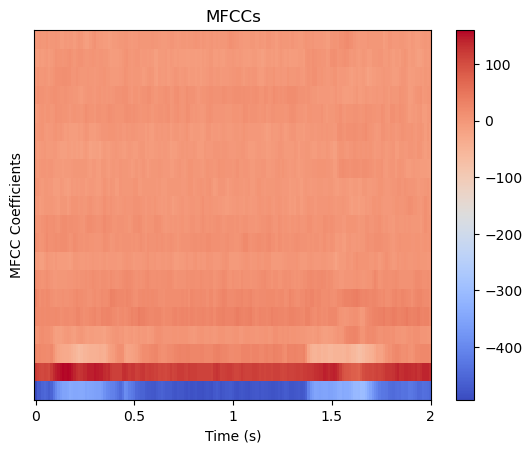

In [8]:
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
librosa.display.specshow(non_wake_mfcc[0], sr=SAMPLE_RATE, x_axis='time')
plt.colorbar()
plt.title("MFCCs")
plt.xlabel("Time (s)")
plt.ylabel("MFCC Coefficients")
plt.show()

### wake word data pre-processing

In [9]:
wake_mfcc = []
# no_of_plots = 30
sub_folder = WAKE
N_MFCC=20   # number of features

chop_duration = 2   # first 2 seconds only
i = 0
for file in p.Path.joinpath(RECORDINGS_PATH, sub_folder).glob("*"):
  y, sr = librosa.load(file, sr=SAMPLE_RATE)

  filename = WAKE_CHOPPED.joinpath(f"chopped_wake{i}.wav")
  sf.write(filename, y[:chop_length], sr)
  mfcc = librosa.feature.mfcc(y=y[:chop_length], sr=sr, n_mfcc=N_MFCC)
  wake_mfcc.append(mfcc)
  i += 1
  print(f"Chopped first {chop_duration} seconds and saved at {filename}")


Chopped first 2 seconds and saved at /home/xd/Documents/wake-word/.data/wake-chopped/chopped_wake0.wav
Chopped first 2 seconds and saved at /home/xd/Documents/wake-word/.data/wake-chopped/chopped_wake1.wav
Chopped first 2 seconds and saved at /home/xd/Documents/wake-word/.data/wake-chopped/chopped_wake2.wav
Chopped first 2 seconds and saved at /home/xd/Documents/wake-word/.data/wake-chopped/chopped_wake3.wav
Chopped first 2 seconds and saved at /home/xd/Documents/wake-word/.data/wake-chopped/chopped_wake4.wav


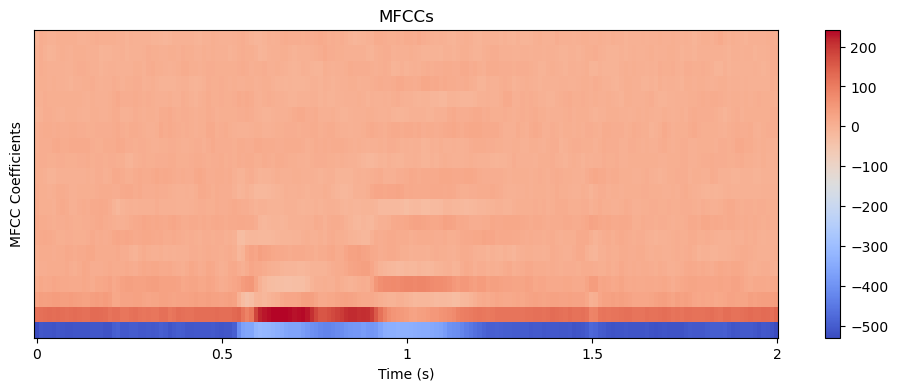

In [10]:
plt.figure(figsize=(12, 4))
librosa.display.specshow(wake_mfcc[1], sr=SAMPLE_RATE, x_axis='time')
plt.colorbar()
plt.title("MFCCs")
plt.xlabel("Time (s)")
plt.ylabel("MFCC Coefficients")
plt.show()

### Augmentation of wake data

In [11]:
# We have to augment the chopped wake samples due to low in count
# Definig some Augmentation utility methods

def random_gain(y, min_db=-6, max_db=6):
  db = random.uniform(min_db, max_db)
  gain = 10.0 ** (db / 20.0)
  return y * gain

def add_background(y, bg, snr_db):
  # adjust background to desired snr relative to signal RMS
  rms_signal = np.sqrt(np.mean(y**2)) + 1e-9
  rms_bg = np.sqrt(np.mean(bg**2)) + 1e-9
  # compute linear scaling for bg
  snr_linear = 10 ** (snr_db / 20.0)
  scale = (rms_signal / (snr_linear * rms_bg))
  bg_scaled = bg * scale
  # trim or pad bg to match length
  if len(bg_scaled) >= len(y):
    start = random.randint(0, len(bg_scaled) - len(y))
    bg_segment = bg_scaled[start:start+len(y)]
  else:
    # repeat bg to fill
    repeats = int(np.ceil(len(y) / len(bg_scaled)))
    bg_tiled = np.tile(bg_scaled, repeats)[:len(y)]
    bg_segment = bg_tiled
  return y + bg_segment

def time_stretch(y, low=0.9, high=1.1):
  rate = random.uniform(low, high)
  # librosa time_stretch expects magnitude STFT -> use effects.time_stretch on waveform via resampling workaround:
  try:
    y_stretched = librosa.effects.time_stretch(y, rate)
  except Exception:
    # fallback: resample (this will change pitch)
    new_len = int(len(y) / rate)
    y_stretched = librosa.resample(y, orig_sr=SAMPLE_RATE, target_sr=int(SAMPLE_RATE*rate))
    y_stretched = librosa.resample(y_stretched, orig_sr=int(SAMPLE_RATE*rate), target_sr=SAMPLE_RATE)
  return y_stretched

def pitch_shift(y, semitones_low=-2, semitones_high=2):
  n_steps = random.uniform(semitones_low, semitones_high)
  return librosa.effects.pitch_shift(y, sr=SAMPLE_RATE, n_steps=n_steps)

def time_shift(y, max_shift_seconds=0.15):
  max_shift = int(max_shift_seconds * SAMPLE_RATE)
  shift = random.randint(-max_shift, max_shift)
  if shift == 0:
    return y
  if shift > 0:
    return np.pad(y, (shift, 0), mode='constant')[:len(y)]
  else:
    return np.pad(y, (0, -shift), mode='constant')[-shift:len(y)-shift]

def add_reverb(y, reverb_scale=0.3):
  # simple exponential impulse response
  ir_len = int(0.03 * SAMPLE_RATE)  # 30 ms IR
  t = np.arange(ir_len) / SAMPLE_RATE
  decay = np.exp(-t * (1.0 + random.random()*10.0))  # random decay rate
  ir = decay
  ir = ir / np.sum(np.abs(ir))
  y_rev = fftconvolve(y, ir)[:len(y)]
  return y * (1 - reverb_scale) + y_rev * reverb_scale

def random_filter(y):
  # light low-pass / high-pass via simple FFT mask
  # For simplicity use librosa.effects.preemphasis as a proxy
  if random.random() < 0.2:
    return librosa.effects.preemphasis(y)
  return y

In [13]:

# load backgrounds into memory for speed
bg_files = [os.path.join(NON_WAKE_DIR, f) for f in os.listdir(NON_WAKE_DIR) if f.endswith(".wav")]
bg_sigs = []
for p in bg_files:
    bg, _ = librosa.load(p, sr=SAMPLE_RATE, mono=True)
    bg_sigs.append(bg)

wake_files = [os.path.join(WAKE_DIR, f) for f in os.listdir(WAKE_DIR) if f.endswith(".wav")]

file_count = 0
for wf in wake_files:
    y, _ = librosa.load(wf, sr=SAMPLE_RATE, mono=True)
    # optional: trim silence
    y, _ = librosa.effects.trim(y, top_db=30)
    for i in range(N_AUG_PER_FILE):
        y_aug = y.copy()
        # order: small random transforms
        if random.random() < 0.6:
            y_aug = time_stretch(y_aug, 0.92, 1.08)
        if random.random() < 0.6:
            y_aug = pitch_shift(y_aug, -1.5, 1.5)
        if random.random() < 0.7:
            y_aug = time_shift(y_aug, max_shift_seconds=0.12)
        if random.random() < 0.8:
            y_aug = random_gain(y_aug, -6, 6)
        if random.random() < 0.7 and len(bg_sigs) > 0:
            bg = random.choice(bg_sigs)
            snr = random.uniform(0, 20)  # 0 dB to 20 dB
            y_aug = add_background(y_aug, bg, snr_db=snr)
        if random.random() < 0.3:
            y_aug = add_reverb(y_aug, reverb_scale=random.uniform(0.05, 0.35))
        y_aug = random_filter(y_aug)
        # normalize to avoid clipping
        max_abs = np.max(np.abs(y_aug)) + 1e-9
        if max_abs > 1.0:
            y_aug = y_aug / max_abs * 0.99
        out_path = os.path.join(WAKE_AUGMENTED_DIR, f"aug_{file_count}.wav")
        sf.write(out_path, y_aug, SAMPLE_RATE)
        file_count += 1

print(f"Created {file_count} augmented files in {WAKE_AUGMENTED_DIR}")

/tmp/ipykernel_12039/2541037519.py:32: FutureWarning: Pass rate=0.9821103640899143 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_stretched = librosa.effects.time_stretch(y, rate)
/tmp/ipykernel_12039/2541037519.py:32: FutureWarning: Pass rate=1.075622964315197 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_stretched = librosa.effects.time_stretch(y, rate)
/tmp/ipykernel_12039/2541037519.py:32: FutureWarning: Pass rate=1.0618107100063308 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_stretched = librosa.effects.time_stretch(y, rate)
/tmp/ipykernel_12039/2541037519.py:32: FutureWarning: Pass rate=1.036355239643476 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_stretched = librosa.effects.time_stretch(y, rate)
/tmp/ipykernel_12039/2541037519.py:32: FutureWarning: Pass rate=0.

Created 150 augmented files in /home/xd/Documents/wake-word/.data/wake-augmented


/tmp/ipykernel_12039/2541037519.py:32: FutureWarning: Pass rate=1.0064438837876861 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_stretched = librosa.effects.time_stretch(y, rate)
